FilFinder Tutorial
===================

The main FilFinder algorithm is implemented in the ```fil_finder_2D``` class. This tutorial goes through the steps to run the entire algorithm.

**NOTE: The example image is simulated data and has a continuous boundary. FilFinder can not yet deal with this case and so the results shown below do not include joining what should be continuous regions.**

Load in the algorithm and along with astropy to read in the FITS file.

In [1]:
from astropy.io import fits
from fil_finder import fil_finder_2D
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (20.0, 16.0)
import matplotlib.pyplot as p
%matplotlib inline

Optional package aplpy could not be imported.


Load in the FITS file containing the simulated image. FilFinder expects a numpy array as an input, along with the image header.

In [2]:
img, hdr = fits.getdata("filaments_updatedhdr.fits", header=True)

Alternatively, the data can be read in using:

In [3]:
fits_hdu = fits.open("filaments_updatedhdr.fits")[0]
img, hdr = fits_hdu.data, fits_hdu.header

Next we initialize the fil_finder_2D object. 

The algorithm requires 3 inputs to begin: the image, header and FWHM beamwidth. In the code below, these are specified by:
1. img - numpy array of the image
2. hdr - the associated header of the image
3. 5.0 - the FWHM beamwidth in arcseconds

The distance is specified with the ```distance``` keyword (in pc). It is optional, however the output will all be in terms of pixel units. Many of the default settings for parameters are dependent on physical scaling; **if no distance is provided, all parameters that have defaults must be specified**. If values are not given, an error will be raised specifying which parameter must be set.

While the algorithm has multiple parameters, these are automatically set to default values which we found work well with the 250 & 350 micron Herschel maps. Some adjustments may be needed when working with data from other sources. A full explanation can be found in [the docs](http://fil-finder.readthedocs.org/en/latest/fil_finder_2d.html) and a shortened version of some of the parameters is given here:
* ```skel_thresh``` - a threshold (given in pixel units) for the minimum pixels a skeleton must contain to be considered (default 0.3 pc)
* ```branch_thresh``` - the minimum length (in pixels) that a branch should have (default 3 $\times$ FWHM beamwidth). This sets one of the skeleton pruning criteria. If the intensity along it is significant to the filament, or if its deletion will change the graph connectivity, it will still be kept.
* ```size_thresh``` - the minimum pixel area a region in the mask should have to be considered a real feature (default $5\pi (0.1\mathrm{pc})^2$). Previous usage of the algorithm has shown the real features tend to be a part of a network and will have large areas that deviate greatly from the elliptical areas. **This parameter likely needs to be altered from the default!**
* ```pad_size``` - number of pixels to pad around each filament (default 10 pixels). This serves 2 purposes: to provide padding along the edges of the image while performing adaptive thresholding and to increase the maximum extent of the radial profiles for each of the filaments. If the size of the adaptive thresholding patch is large, this may need to be increased.
* ```flatten_thresh``` - the flattening threshold that sets the normalization to use in the arctan transform (flattens bright, compact regions). When specified, it corresponds to the percentile of the intensity distribution (0-100). This parameter is set automatically by fitting a log-normal distribution to the intensities in the images and setting the threshold to $\mu + 2\sigma$. The simulated image presented here doesn't follow a log-normal very well and we seem to get better results by setting it to the 95% percentile.
* ```glob_thresh``` - a global threshold that sets the percentile of data to ignore. This is intended to remove noisy regions of the data. If no value is given, the algorithm does not apply any global thresholding and used the entire image. For this tutorial, the 20% percentile is used as the cutoff.

In [4]:
fils = fil_finder_2D(img, hdr, 10.0, distance=260, glob_thresh=20, flatten_thresh=95)

The algorithm has several steps, which will be outlined below. Using the ```run``` function will perform all the steps in one with the algorithm defaults. For greater control of each step, each step can be run, which is shown in this tutorial.

Masking
=======

We begin by creating the mask of the image. All of the parameters are set by default based on physical parameters. However this simulation doesn't quite adhere to these and so the effect of manipulating these parameters is shown in the next few steps.

**NOTE:** A pre-made mask can be specified if you already have computed one, or have one from another source. Specify the mask using the ```mask``` keyword while creating the ```fil_finder_2D``` object (as shown above). Then enable its use by specifying ```use_existing_mask=True``` in the line below.

/Users/eric/anaconda/lib/python2.7/site-packages/skimage/morphology/misc.py:119: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warnings.warn("Only one label was provided to `remove_small_objects`. "
/Users/eric/Dropbox/code_development/filaments/fil_finder/filfind_class.py:378: RuntimeWarning: invalid value encountered in less
  self.image[np.where((self.mask * self.image) < 0.0)] = 0


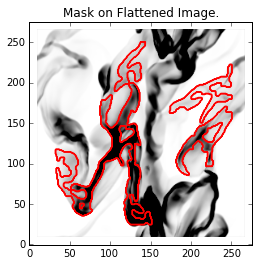

In [5]:
fils.create_mask(verbose=True)


Here is the default mask. The algorithm has picked out some of the filamentary structure, but there most of the structure is ignored. The mask is not able to go to the edges of the image, due to the padding with ``` NaNs ```. To fix this, we invoke the `border_masking=False` input. For observational data, the edges are often dominated by noisy artifacts, but in this simulated image, there is usable data right to the edges.

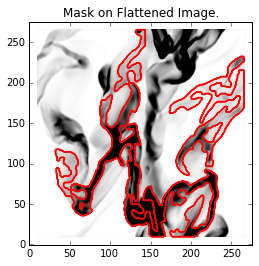

In [6]:
fils.create_mask(verbose=True, border_masking=False, use_existing_mask=False)

This is an improvement, but a lot of the structures remain ignored. As stated above, the default value for ```size_thresh``` may need to be altered, and it certainly does for this image. After trying a few values, an area of 430 pixels seems to work very well.

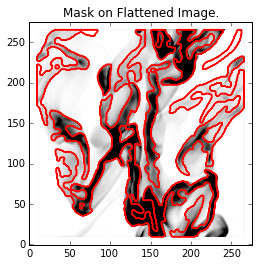

In [17]:
fils.create_mask(verbose=True, border_masking=False, size_thresh=430, use_existing_mask=False)

That's better! Not only are the small scale features better characterized, but some additional faint regions have also been picked up.

With well-defined regions, the skeletons can now be found using a Medial Axis Transform.

Skeletons
=========

The next step in the algorithm is to use a Medial Axis Transform to return the skeletons of the regions. These skeletons are the actual objects used to derive the filament properties. We make the assumption that the skeletons run along the ridge of the filament so that they can be defined as the centers.

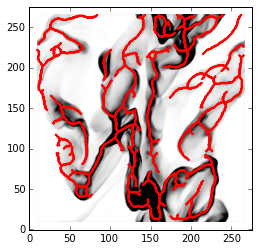

In [19]:
fils.medskel(verbose=True)

Pruning and Lengths
------------------

Now begins the analysis of the filaments! This begins with finding the length. The skeletons are also pruned during this process to remove short branches which aren't essential. This is preferable over traditional pruning methods which shorten the entire skeleton.

A whole ton of information is printed out when verbose mode is enabled.
* The first set show the skeletons segmented into their branches (and intersections have beem removed). Their connectivity graphs are also shown. Their placement is unfortunately only useful for small structures.
* Next, the longest paths through the skeleton are shown. This is determined by the length of the branch and the median brightness along it relative to the rest of the structure. These lengths are classified as the main length of the filament.
* The final set shows the final, pruned skeletons which are recombined into the skeleton image to be used for the rest of the analysis.

The parameter ```skel_thresh``` sets the minimum pixels a skeleton must contain (roughly the minimum length). By default, this is set in pixel units to correspond to 0.3 pc (giving an aspect ratio of 3 for the average filament). This cuts off a small, real feature in the simulated image, so it has been lowered to 20 pixels (~0.15 pc). Multiple other parameters may be set for this stage; see the documentation for a full explanation of each.

Filament: 1 / 9


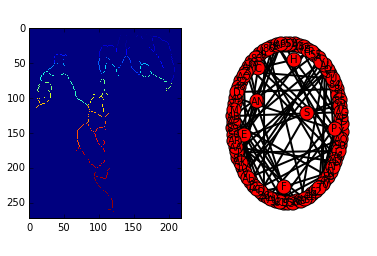

Filament: 2 / 9


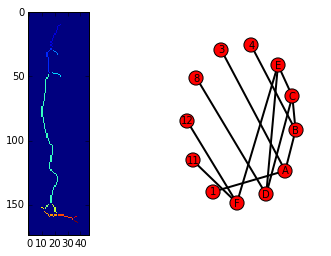

Filament: 3 / 9


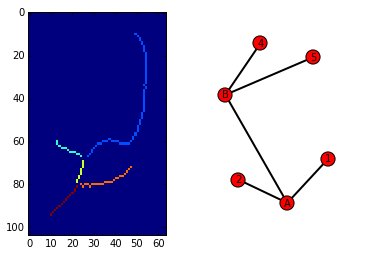

Filament: 4 / 9


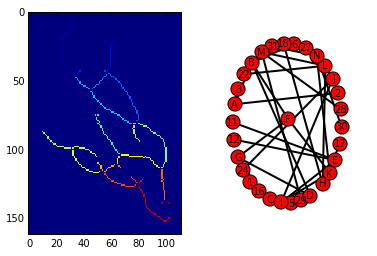

Filament: 5 / 9


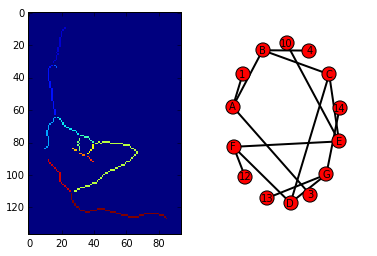

Filament: 6 / 9


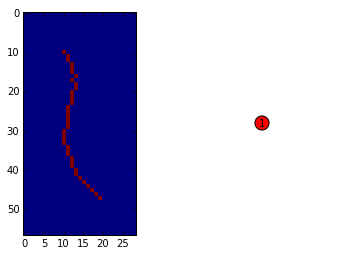

Filament: 7 / 9


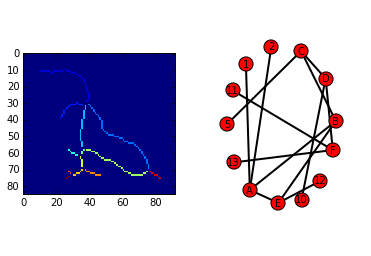

Filament: 8 / 9


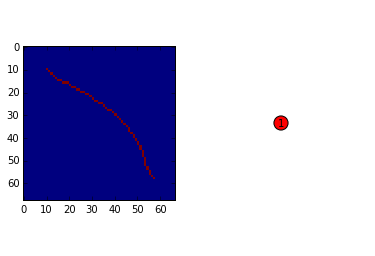

Filament: 9 / 9


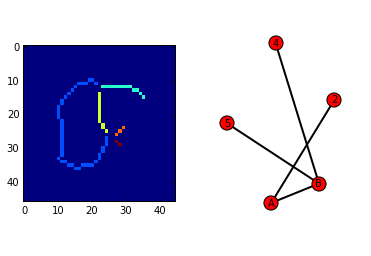

Filament: 1 / 9


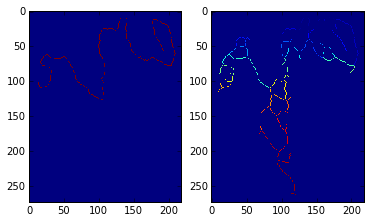

Filament: 2 / 9


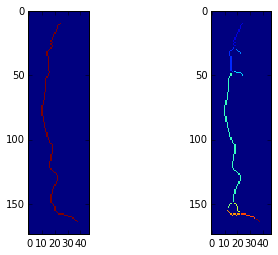

Filament: 3 / 9


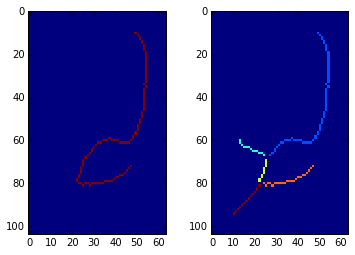

Filament: 4 / 9


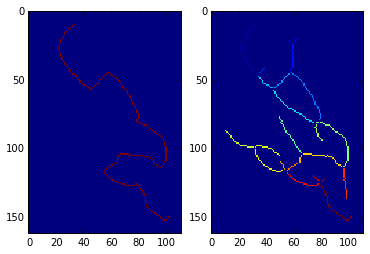

Filament: 5 / 9


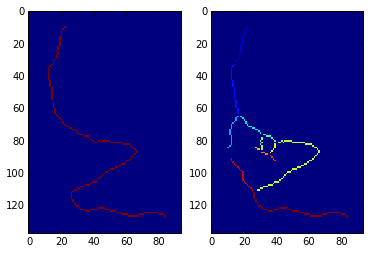

Filament: 6 / 9


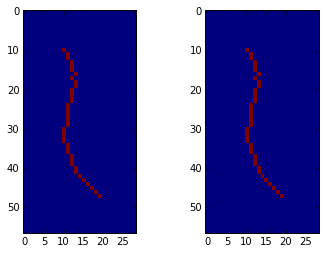

Filament: 7 / 9


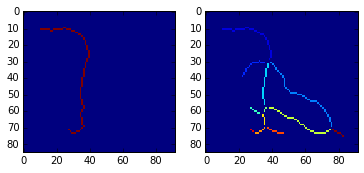

Filament: 8 / 9


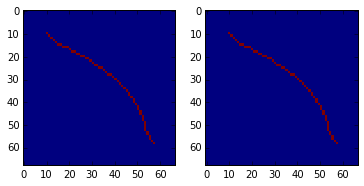

Filament: 9 / 9


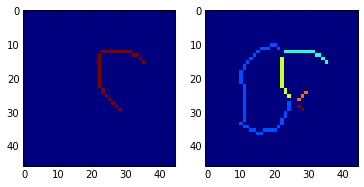

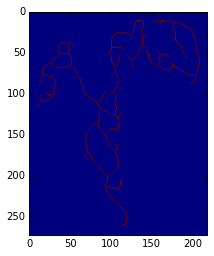

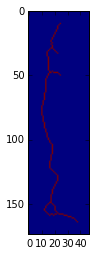

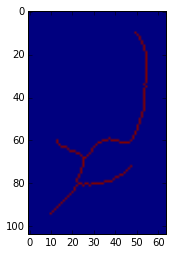

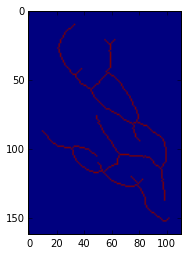

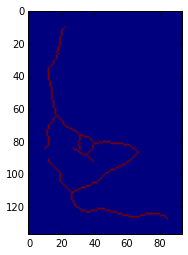

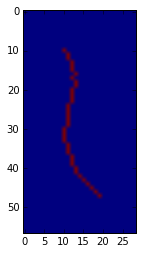

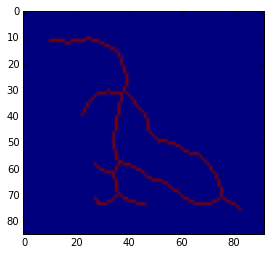

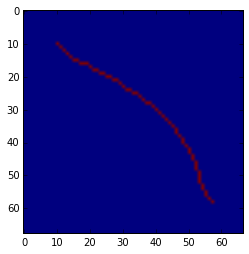

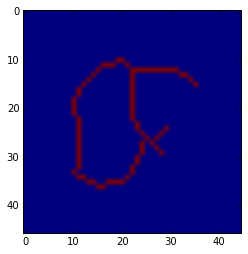

In [20]:
fils.analyze_skeletons(verbose=True, skel_thresh=20.0)

Let's plot the final skeletons before moving on:

<matplotlib.contour.QuadContourSet instance at 0x10b361cf8>

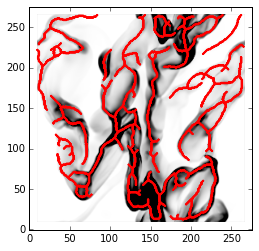

In [21]:
import numpy as np
vmin = np.percentile(fils.flat_img[np.isfinite(fils.flat_img)], 20)
vmax = np.percentile(fils.flat_img[np.isfinite(fils.flat_img)], 90)
p.imshow(fils.flat_img, interpolation=None, origin="lower",
         cmap='binary', vmin=vmin, vmax=vmax)
p.contour(fils.skeleton, colors='r')

The original skeletons didn't contain too many spurious features, so there is relatively little change.

Curvature and Direction
=======================

Following this step, we use a version of the [Rolling Hough Transform (RHT)](http://adsabs.harvard.edu/abs/2014ApJ...789...82C) to find the orientation of the filaments (median of transform) and their curvature (IQR of transform).

The polar plots shown plot $2\theta$. The transform itself is limited to $(-\pi/2, \pi/2)$ since the direction is ambiguous. The first plot shows the transform distribution for that filament. Beside it is the CDF of that distribution. 

By default, the transform is applied on the longest path of the skeleton. It can also be applied on a per-branch basis by enabling the ```branches=True``` when running ```exec_rht```. This destroys information of the filaments relative to each other, but gives a better estimate for the image as a whole.

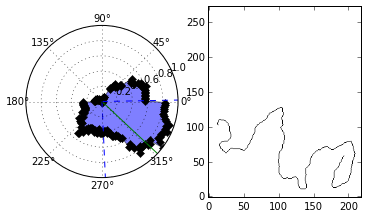

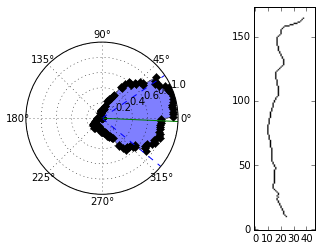

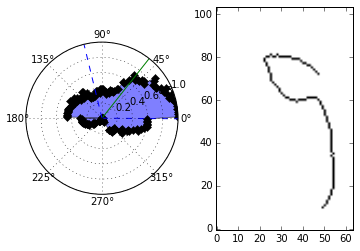

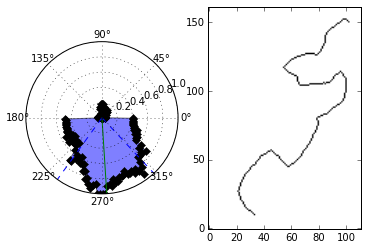

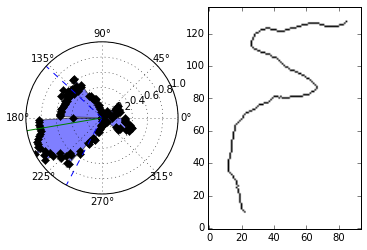

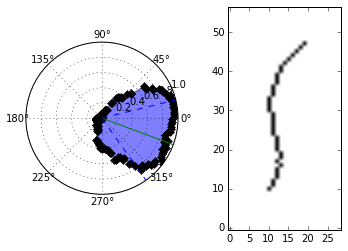

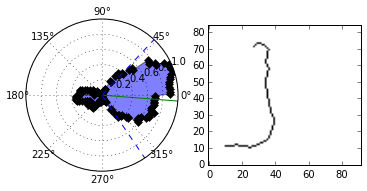

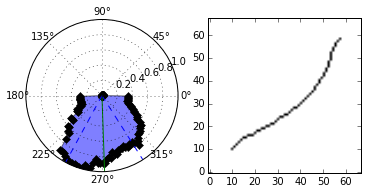

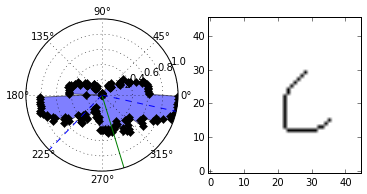

In [22]:
fils.exec_rht(verbose=True)

Widths
======

One of the final steps is to find the widths of the filaments. This is accomplished by building a radial profile along the filament, defining the skeleton as the middle. Pixels are binned based on their minimum distance from the nearest skeleton pixel. Pixels can only belong to one skeleton, the skeleton to which it is closest.

`fil_finder` supports three different models to fit to the radial profiles. By default, a Gaussian with a constant background is used. Using the `fit_model` parameter, a Lorentzian model or radial cylindrical model can also be specified (imported from `fil_finder.widths`). **The Gaussian model is the most tested and is recommended for most uses**.

With some images, a small number of profiles were not well fit by these idealized cases. For these, there is a non-parameteric method that simply estimates a peak and background and interpolates between them to estimate the width. This is enabled, by default, using the `try_nonparam` keyword in ```find_widths```. If a fit returns a bad fit (based on it reduced $\chi^2$ value), the non-parameteric method is attempted. Most of the cases where the non-parametric method is used correspond to regions that have many neighbouring filaments and the number of pixels belonging to a single filament decreases greatly.

Fits are rejected based on a set of criteria:
* Background is above the peak
* Errors are larger than the respective parameters
* The width is too small to be deconvolved from the beamwidth
* The width is not appreciably smaller than the length
* The non-parametric method cannot find a reasonable estimate

*Note:* Each profile is plotted before invoking the rejection criteria. This is why some of the plots below may look suspect. The fitted lines are based on the model given (gaussian for this case) and since the non-parameteric method is not quite this profile, those fits will appear to be overestimated.

**The order of the parameter values shown is: Amplitude, Width, Background, FWHM.**

0 in 9
Fit Parameters: [ 1.21668023  0.02124517  0.03696883  0.04974136] 
Fit Errors: [ 0.00731132  0.0005588   0.00338501  0.00056203]
Fit Type: gaussian


/Users/eric/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/eric/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


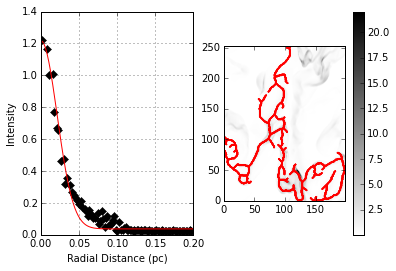

1 in 9
Fit Parameters: [ 0.95279165  0.02563813  0.1323161   0.06013541] 
Fit Errors: [ 0.01423218  0.00146024  0.01652742  0.00146601]
Fit Type: gaussian


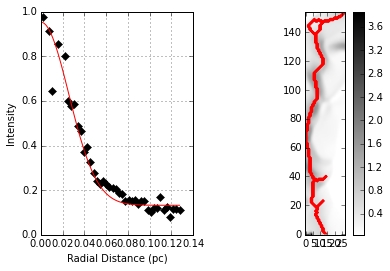

2 in 9
Fit Parameters: [ 0.89174371  0.02218852  0.0421009   0.05197505] 
Fit Errors: [ 0.00368373  0.00035653  0.00128532  0.00035842]
Fit Type: gaussian


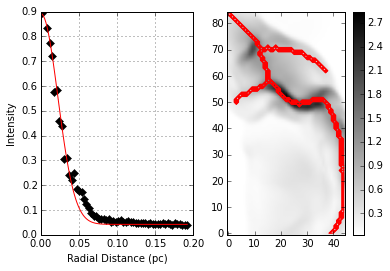

3 in 9
Fit Parameters: [ 0.24338281  0.03109455  0.00894615  0.07302615] 
Fit Errors: [ 0.00186556  0.00078178  0.00075667  0.00078387]
Fit Type: gaussian


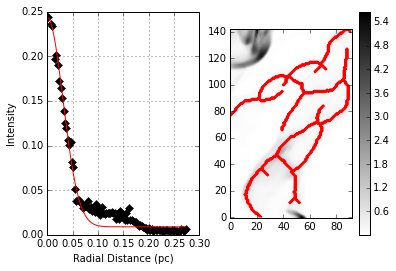

4 in 9
Fit Parameters: [ 0.21637956  0.02592195  0.05065622  0.06080638] 
Fit Errors: [ 0.00210418  0.00137818  0.00376132  0.00138351]
Fit Type: gaussian


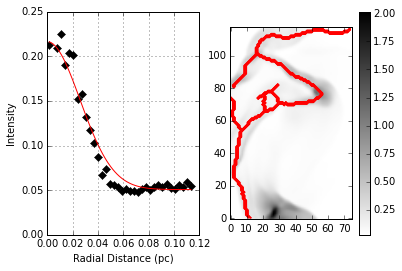

5 in 9
Fit Parameters: [ 0.87411381  0.02864932  0.02732485  0.0672513 ] 
Fit Errors: [ 0.01227808  0.002576    0.02013661  0.00258415]
Fit Type: gaussian


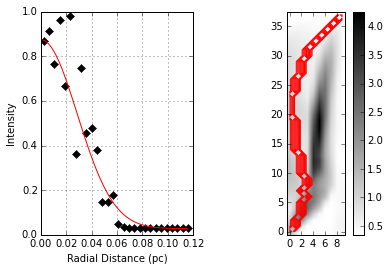

6 in 9
Fit Parameters: [ 1.77485015  0.02117793  0.0274767   0.04958209] 
Fit Errors: [ 0.0235329   0.00108317  0.00371031  0.00108946]
Fit Type: gaussian


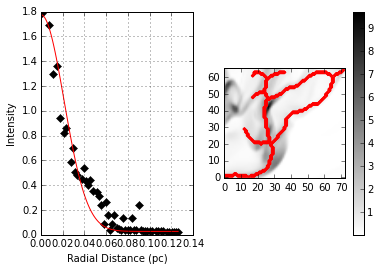

7 in 9
Fit Parameters: [ 0.06216382  0.01755329  0.02666746  0.04098678] 
Fit Errors: [ 0.00026488  0.00087021  0.00125604  0.0008776 ]
Fit Type: gaussian


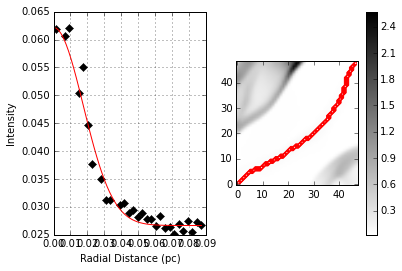

8 in 9
Fit Parameters: [ 2.74542574  0.01968595  0.15089129  0.04604678] 
Fit Errors: [ 0.02401156  0.00065985  0.01193258  0.0006643 ]
Fit Type: gaussian


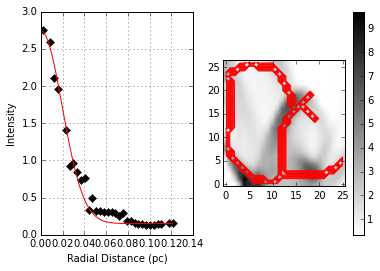

In [23]:
fils.find_widths(verbose=True)

All of the fits in this image correspond well to a Gaussian profile. Note the large range of peak amplitudes in the fits; #8 peaks near 3 K, while #7 peaks much lower at 0.060 K.

Further Methods and Properties
==============================

While the above represent the major filamentary properties, some others can also be computed.

As part of the width finding function, the sum of the intensity within the filament's width is found. It requires information from the radial profiles, which are not returned, and is therefore lopped into that process. They can be accessed by `fils.total_intensity`.

The median intensity of each filament can also be found using the function `fils.compute_filament_brightness`. This estimate is along the ridge of the filament, unlike `fils.total_intensity` which is within the fitted width.

Finally, we can model the filamentary network found in the image using `fils.filament_model`. Using the fitted profile information, filaments whose fits did not fail can be estimated. For this image, the model is shown below.

<matplotlib.colorbar.Colorbar instance at 0x10a19f128>

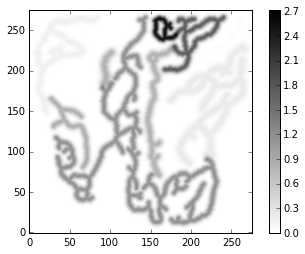

In [25]:
p.imshow(fils.filament_model(), interpolation=None, origin='lower', cmap='binary')
p.colorbar()

Though not a perfect representation, it gives an esimate of the network and the relation of the intensity in the network versus the entire image. This fraction is computed by the function `fils.find_covering_fraction`:

In [27]:
fils.find_covering_fraction()
print fils.covering_fraction

0.622995650734


Approximately 60% of the total intensity in the image is coming from the filamentary network. This seems reasonable, as the algorithm inherently ignores compact features, whose intensities generally greatly exceed that of the filaments.

Saving Outputs
==============

Saving of outputs created by the algorithm are split into 2 functions.

Numerical data is dealt with using `fils.save_table`. This combines the results derived for each of the portions into a final table. We use the [astropy.table](http://astropy.readthedocs.org/en/latest/table/) package to save the results. Currently, the type of output is specified through `table_type` and accepts 'csv', 'fits', and 'latex' as valid output types. If the output is saved as a fits file, branch information is not saved as BIN tables do not accept lists as an entry. The data table created can be accessed after through `fils.dataframe`, which is accepted by the `Analysis` object.

Image products are saved using `fils.save_fits`. By default, the mask, skeleton, and model images are all saved. Saving of the model can be disabled through `model_save=False`. The output skeleton FITS file has one extension of the final, cleaned skeletons, and a second containing only the longest path skeletons. Optionally, stamp images of each individual filament can be created. These contain a portion of the image, the final skeleton, and the longest path in the outputted FITS file. The files are automatically saved in a 'stamps_(save_name)' folder.